# Stock Portfolio Optimization - Data Extraction and Storing in MySQL Database

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import seaborn as sns

### Define the tickers and the date range

In [2]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)
print(start_date)

2019-06-24 16:40:30.432232


### Download the Adjusted Close Price

It ensures the dividend is weighted in the portfolio

In [3]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-06-24  271.401154  72.700569  133.940002  182.560165  138.870605
2019-06-25  268.739258  72.726891  134.199997  179.426285  137.554749
2019-06-26  268.471130  72.560287  132.970001  180.260696  137.295273
2019-06-27  269.423096  72.770699  132.839996  180.949554  138.120010
2019-06-28  270.809601  72.832100  133.199997  181.182388  139.083725
...                ...        ...         ...         ...         ...
2024-06-14  541.034607  72.660004  215.729996  479.190002  266.690002
2024-06-17  545.340637  72.389999  214.610001  485.059998  268.720001
2024-06-18  546.726196  72.639999  215.470001  485.209991  269.399994
2024-06-20  545.240967  72.500000  218.160004  481.470001  268.720001
2024-06-21  544.510010  72.519997  214.779999  480.179993  268.309998

[1258 rows x 5 columns]


### Calculate the daily returns using Lognormal

In [4]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

### Data Wrangling
#### Handling Missing Value

In [5]:
log_returns[log_returns.isnull().any(axis=1)]

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2019-06-24,NaN,NaN,NaN,NaN,NaN


In [6]:
# the first row is null due to the lognormal calculation and is therefore removed from the dataframe
log_returns = log_returns.dropna()
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2019-06-25,-0.009856,0.000362,0.001939,-0.017315,-0.009521
2019-06-26,-0.000998,-0.002293,-0.009208,0.004640,-0.001888
2019-06-27,0.003540,0.002896,-0.000978,0.003814,0.005989
2019-06-28,0.005133,0.000843,0.002706,0.001286,0.006953
2019-07-01,0.009037,-0.000072,-0.019559,0.013405,0.007038
...,...,...,...,...,...
2024-06-14,0.000608,0.001515,0.012876,0.005168,-0.000750
2024-06-17,0.007927,-0.003723,-0.005205,0.012175,0.007583
2024-06-18,0.002538,0.003448,0.003999,0.000309,0.002527


### Covariance Matrix

In [7]:
cov_matrix = log_returns.cov()*252 #annualized covariance 
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.044022  0.002956  0.003943  0.049595  0.045076
BND  0.002956  0.004812  0.003887  0.003587  0.003149
GLD  0.003943  0.003887  0.023460  0.005299  0.004165
QQQ  0.049595  0.003587  0.005299  0.064386  0.050730
VTI  0.045076  0.003149  0.004165  0.050730  0.046531


<Axes: >

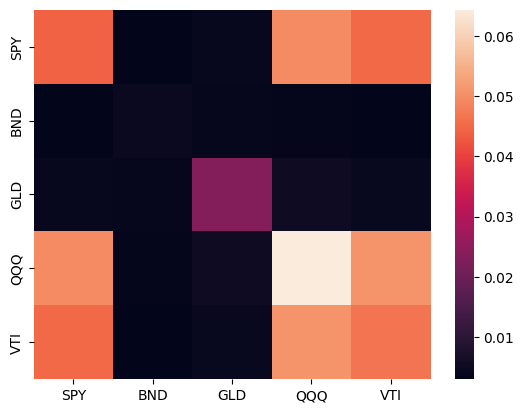

In [8]:
sns.heatmap(cov_matrix)

### Portfolio Metrics

#### 1. Portfolio Risk or Standard Deviation($\sigma$)

In [9]:
def std_dev(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#### 2. Expected Return of the Portfolio

*Based on the assumption that the future returns are based on historical returns.*

In [10]:
def exp_returns(weights, log_returns):
    return np.sum(log_returns.mean()*weights*252) #annualized return

#### 4. Sharpe ratio 

Considers the total (systematic ($\beta$) and unsystematic) risk ($\sigma$).

$\text{Sharpe Ratio} = \frac{\text{Portfolio Return}(R_p) - \text{Risk Free Rate}(R_f)}{\sigma}$

In [11]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (exp_returns(weights, log_returns) - risk_free_rate) / std_dev(weights, cov_matrix)

### Retrieving the Risk Free Rate

The ten-year treasury rate obtained from FRED API is used as the risk free rate parameter in this portfolio optimization

In [12]:
from fredapi import Fred

fred = Fred(api_key='70a5960bdec357f09a4d4922e4c749d7')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100 #convert the whole number into percentage
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.044800000000000006


### Portfolio Optimization

#### 1. Negative Sharpe Ratio

To obtain the maximum Sharpe ratio to be used by scipy.optimize.minimize() function

In [13]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### 2. Define the Constraints and Bounds

a. Constraint: The sum of the weights should be equal to 1.

b. Bound: The percentage of stock from a single ticker. It should be greater than or equal to 0 or less than 50% to minimize the imbalance.

In [14]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bound = [(0, 0.5) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights) # it will be 20% as there are 5 tickers in this portfolio

[0.2 0.2 0.2 0.2 0.2]


#### 3. Optimizing the Weights

To Maximize the Sharpe Ratio

SLSQP: Sequential Least Square Quadratic Programming method is used with the minimize function. It is a numerical optimization technique suitable for solving non-linear optimization problems with constraints

In [15]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method = 'SLSQP', constraints = constraints, bounds = bound)
optimized_weights = optimized_results.x

#### 4. Analyzing the Optimal Portfolio

In [16]:
print("Optimized Weights: ")
for ticker, weight in zip(tickers, optimized_weights):
    print(f'{ticker}: {weight:.4f}')

print()

optimal_portfolio_returns = exp_returns(optimized_weights, log_returns)
optimal_portfolio_volatility = std_dev(optimized_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f'Expected Annual Return: {optimal_portfolio_returns:.4f}')
print(f'Expected Annual Volatility: {optimal_portfolio_volatility:.4f}')
print(f'Sharpe Ratio: {optimal_sharpe_ratio:.4f}')

Optimized Weights: 
SPY: 0.0000
BND: 0.0000
GLD: 0.5000
QQQ: 0.5000
VTI: 0.0000

Expected Annual Return: 0.1443
Expected Annual Volatility: 0.1569
Sharpe Ratio: 0.6341


#### 5. Visualization of Optimal Portfolio

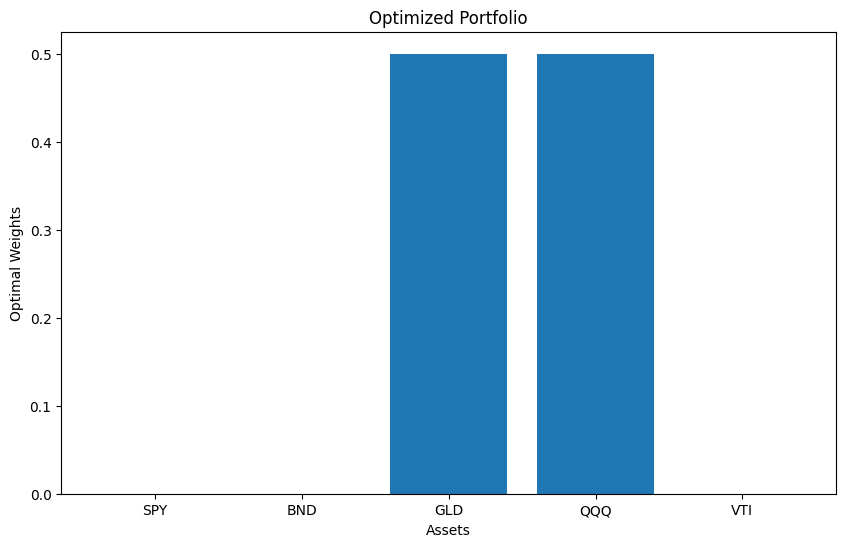

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(tickers, optimized_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimized Portfolio')
plt.show()